In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

cuda


In [2]:
!wget https://voiceage.com/wbsamples/in_stereo/Classical.wav

--2024-09-20 04:37:59--  https://voiceage.com/wbsamples/in_stereo/Classical.wav
Resolving voiceage.com (voiceage.com)... 24.37.80.233
Connecting to voiceage.com (voiceage.com)|24.37.80.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1933968 (1.8M) [audio/x-wav]
Saving to: 'Classical.wav'

Classical.wav       100%[===================>]   1.84M  2.94MB/s    in 0.6s    

2024-09-20 04:38:00 (2.94 MB/s) - 'Classical.wav' saved [1933968/1933968]



In [3]:
from IPython.display import Audio
Audio('Classical.wav')

In [4]:
import torchaudio
audio, sr = torchaudio.load('./Classical.wav')

In [5]:
print(sr)
print(audio.shape)
audio = audio[0]

48000
torch.Size([2, 483481])


In [6]:
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

Audio length: 10.072520833333334 seconds


In [7]:
audio

tensor([0.0083, 0.0122, 0.0155,  ..., 0.0000, 0.0000, 0.0000])

In [8]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

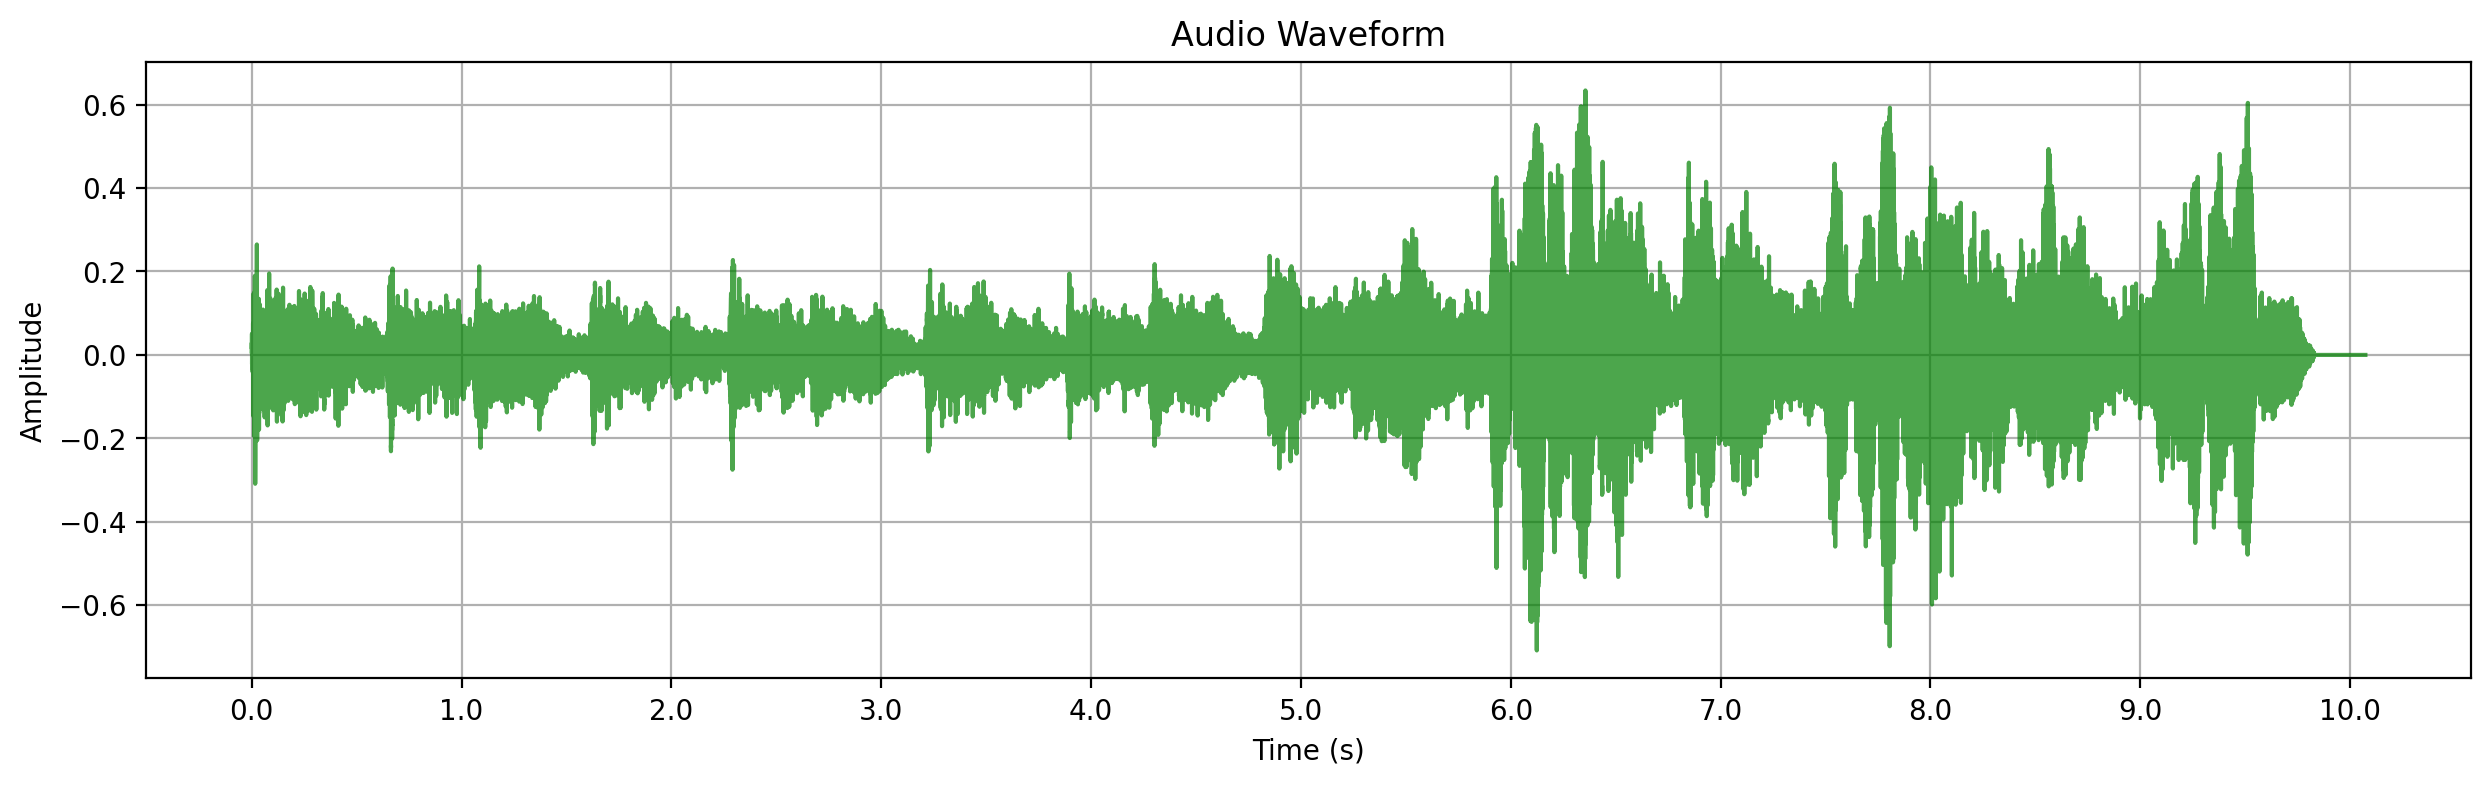

In [9]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [10]:
audio = audio[: 5 * sr]
print(audio.shape)
print(audio)

torch.Size([240000])
tensor([ 0.0083,  0.0122,  0.0155,  ..., -0.0782, -0.0750, -0.0737])


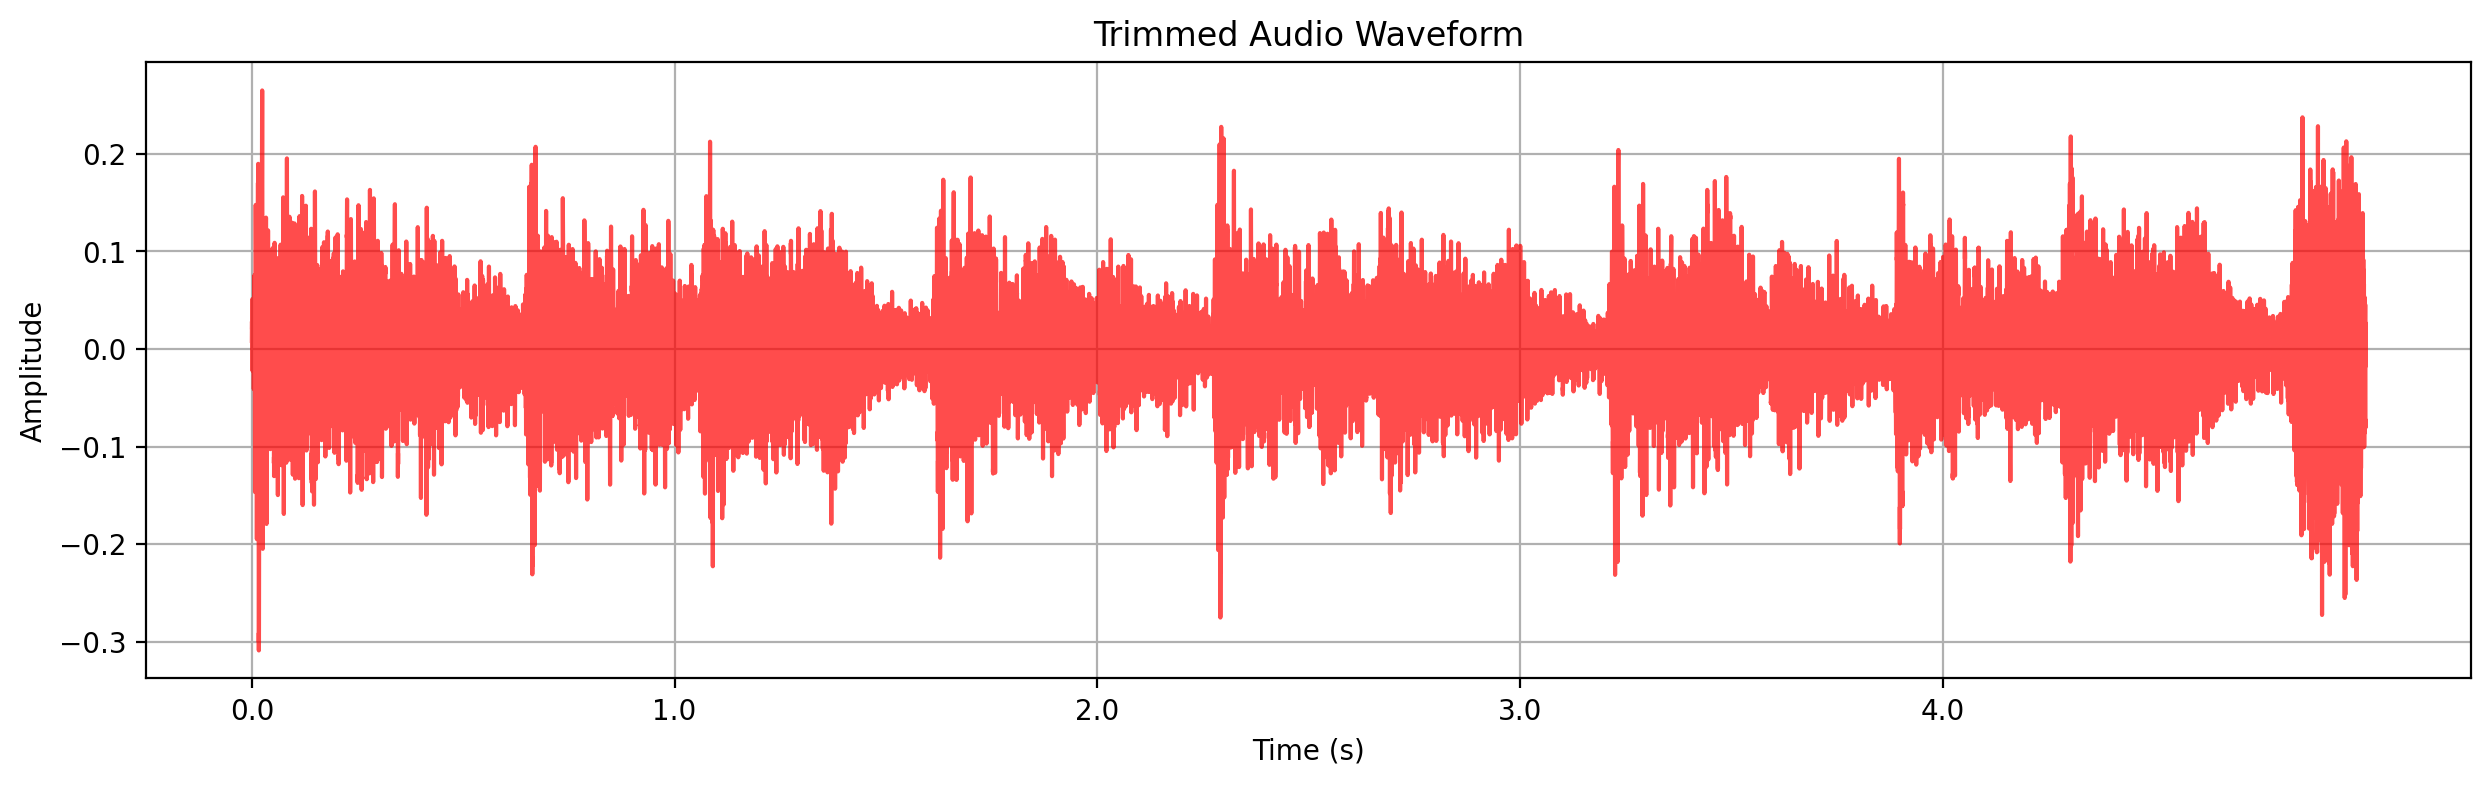

In [11]:
audio_plot(audio, sr, 'red', 'Trimmed Audio Waveform')

In [12]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([240000, 1])
tensor([[-100.0000],
        [ -99.9992],
        [ -99.9983],
        ...,
        [  99.9983],
        [  99.9992],
        [ 100.0000]])


In [13]:
Audio(audio, rate = sr)

In [14]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [15]:
num_features = 10000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([240000, 10000])
tensor([[-1.3291e-02, -1.1266e-02,  6.8662e-03,  ...,  1.3997e-02,
         -7.1404e-03, -1.3975e-02],
        [-1.2896e-02, -1.0565e-02,  6.8096e-03,  ...,  1.3797e-02,
         -9.1018e-03, -1.4142e-02],
        [-1.2430e-02, -9.7989e-03,  6.7520e-03,  ...,  1.3505e-02,
         -1.0819e-02, -1.3986e-02],
        ...,
        [ 1.3595e-02, -2.7058e-03,  8.9127e-04,  ...,  1.1953e-02,
          1.3975e-02,  5.3020e-05],
        [ 1.3273e-02, -1.6279e-03,  8.2665e-04,  ...,  1.1327e-02,
          1.3407e-02, -2.0664e-03],
        [ 1.2869e-02, -5.1277e-04,  7.6115e-04,  ...,  1.0631e-02,
          1.2440e-02, -4.1656e-03]])


In [25]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(240000,)


In [27]:
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

In [28]:
print(pred_audio)
print(audio)

[ 0.04847069  0.0395691   0.03644295 ... -0.08987121 -0.10429077
 -0.12491302]
tensor([ 0.0083,  0.0122,  0.0155,  ..., -0.0782, -0.0750, -0.0737])


In [29]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(9.277388, 3551.7693)

In [30]:
Audio(pred_audio, rate = sr)

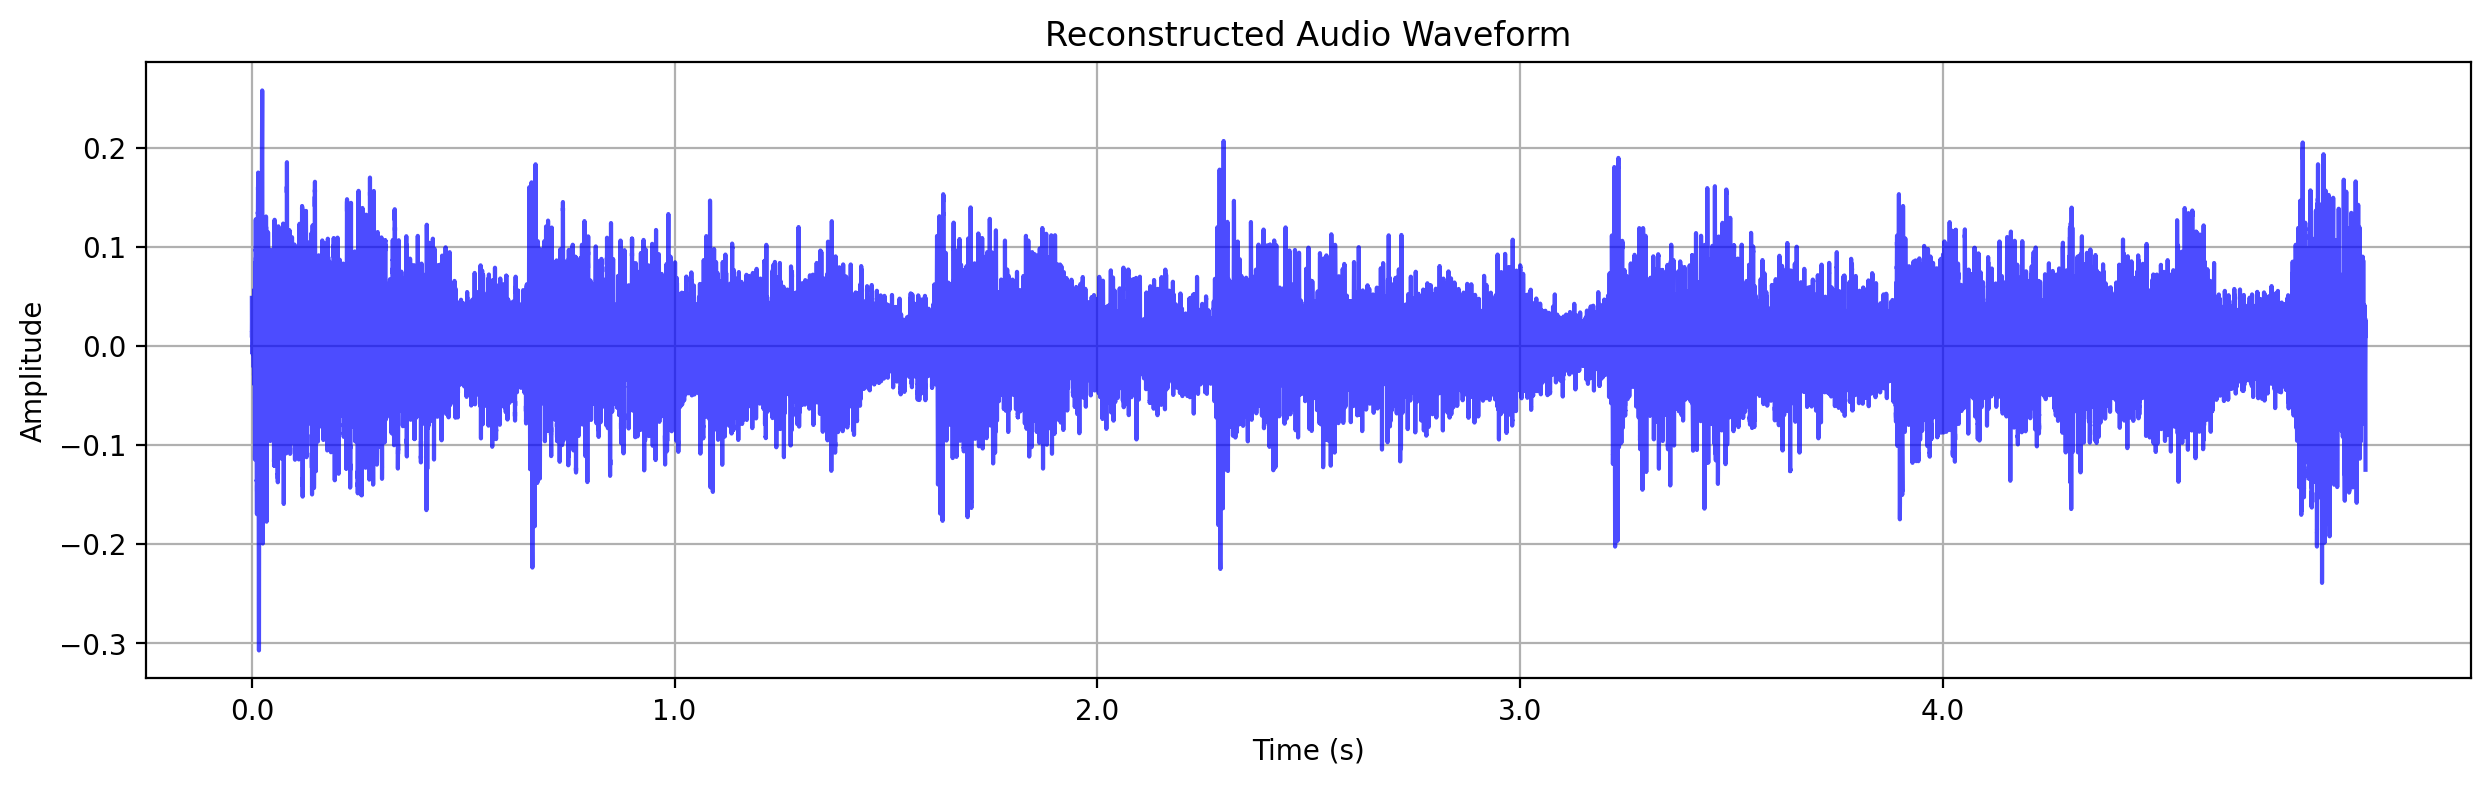

In [31]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

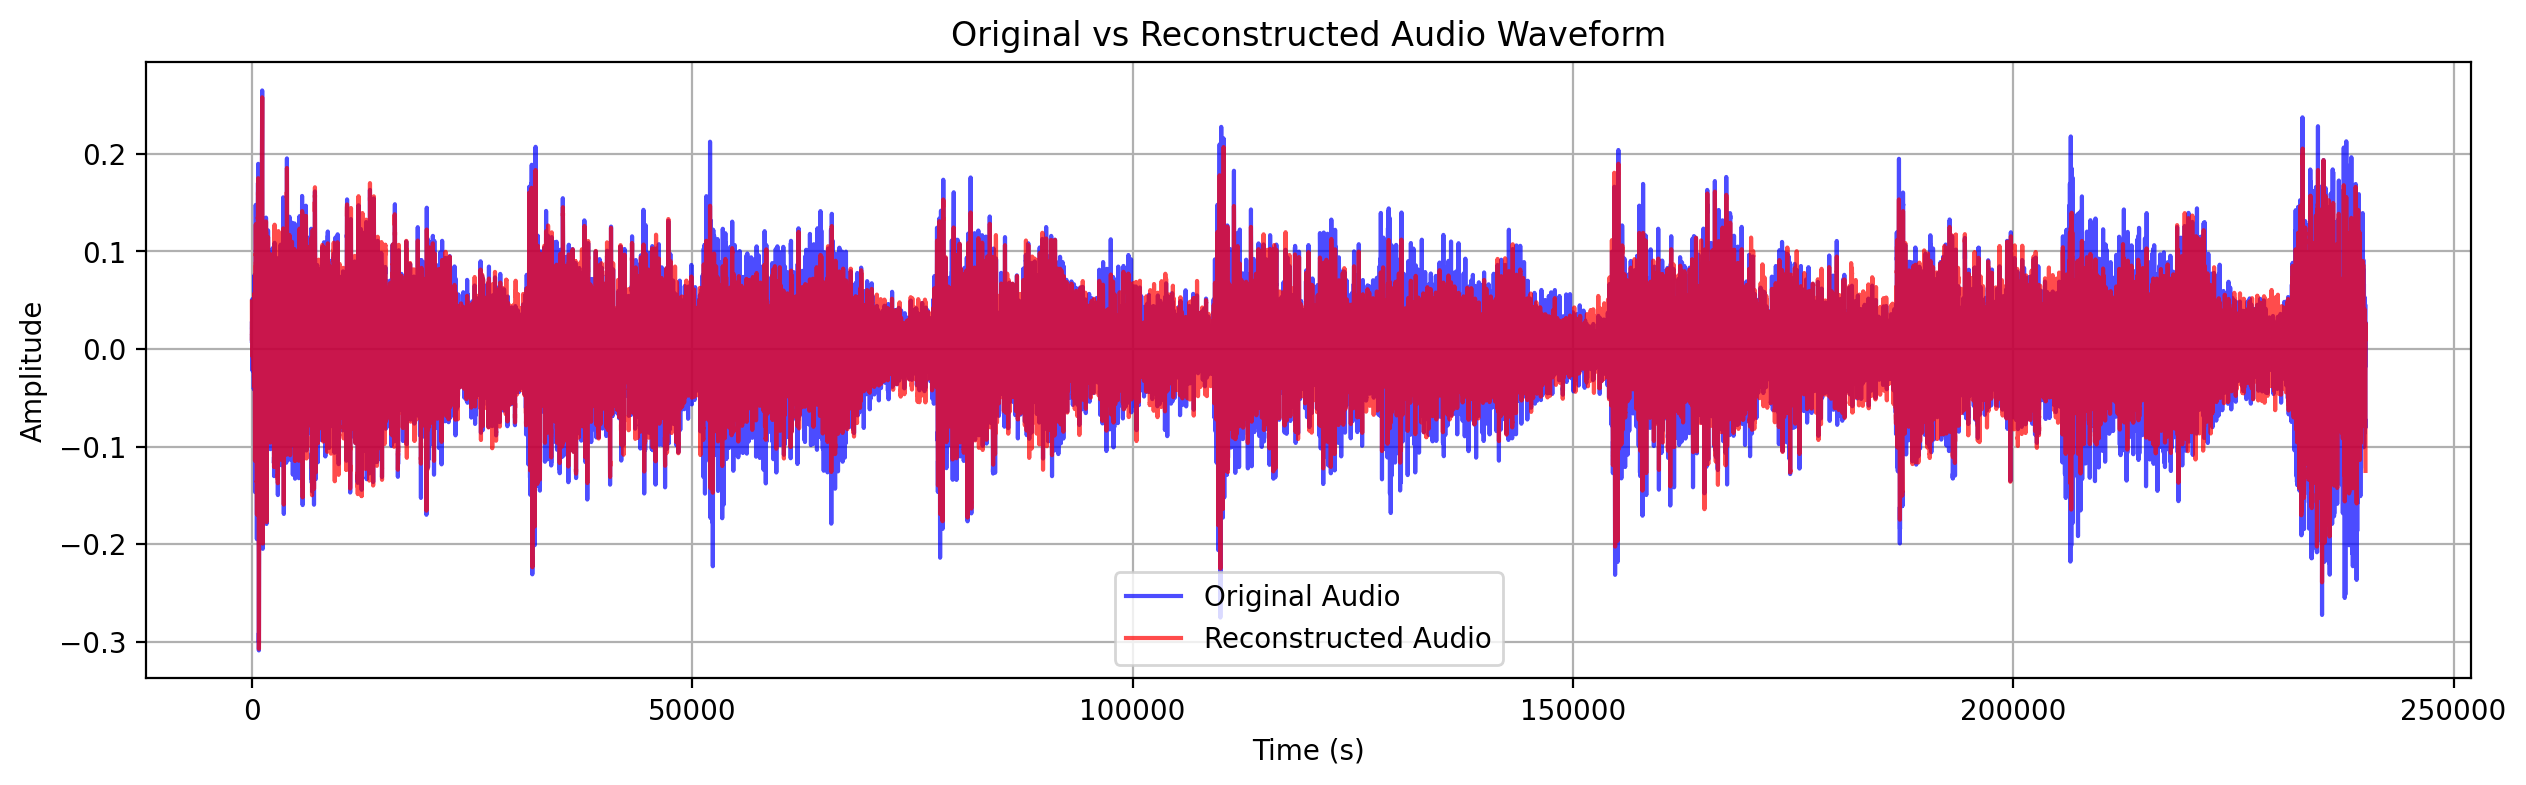

In [32]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [35]:
def calculate_rmse(audio, pred_audio):
    """Calculate the Root Mean Squared Error (RMSE) between original and reconstructed audio signals."""
    # Ensure the inputs are numpy arrays
    original = np.array(audio)
    reconstructed = np.array(pred_audio)

    rmse = np.sqrt(np.mean((original - reconstructed) ** 2))
    return rmse

rmse_value = calculate_rmse(audio, pred_audio)
print(f"RMSE: {rmse_value}")

RMSE: 0.01893739216029644


In [36]:
def calculate_snr(audio, pred_audio):
    """Calculate the Signal-to-Noise Ratio (SNR) between original and reconstructed audio signals."""
    # Ensure the inputs are numpy arrays
    original = np.array(audio)
    reconstructed = np.array(pred_audio)
    
    # Calculate signal power (variance of the original signal)
    signal_power = np.var(original)
    
    # Calculate noise power (variance of the difference between original and reconstructed signals)
    noise_power = np.var(original - reconstructed)
    
    # Calculate SNR in dB
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

snr_value = calculate_snr(audio, pred_audio)
print(f"SNR: {snr_value} dB")

SNR: 8.331078886985779 dB
